<a href="https://colab.research.google.com/github/farenga/tf-neural-ode/blob/main/torch_neuralode_conv_dlrom_2_quasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/rtqichen/torchdiffeq

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-z0we6eej
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-z0we6eej
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.2-py3-none-any.whl size=31200 sha256=6294523d18f39dedb2c499efe85484bb02d7ebe1f8ed8544c09aa51f258aa840
  Stored in directory: /tmp/pip-ephem-wheel-cache-iid5hlh3/wheels/42/b5/d4/aeb3622995bff5e90fcc0c0ef799a6951e48daaf17e293281e
Successfully built torchdiffeq


In [ ]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from IPython.display import display, clear_output
gpu = '0'
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [13]:
block_size = 400
train_size = 400
leave_out_for_time_test = block_size - train_size
batch_time = 200
batch_size = 20
niters = 2000
freq = 100
scaled = False
zeroflow = True
latent_dim = 2
n_params = 1

n_ensemble = 20
n_hidden = 128

data_noise = 0.001
n_data = batch_time
W1_var = 20. 
W_last_var = 1/n_hidden
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var


In [ ]:
!ls

sample_data  S_latent_test_20_DLROM.mat  S_latent_train_20_DLROM.mat


In [ ]:
train_mat = scipy.io.loadmat('S_latent_train_20_DLROM.mat')
test_mat = scipy.io.loadmat('S_latent_test_20_DLROM.mat')
train_set = torch.tensor(train_mat['S'])
test_set = torch.tensor(test_mat['S'])

ValueError: ignored

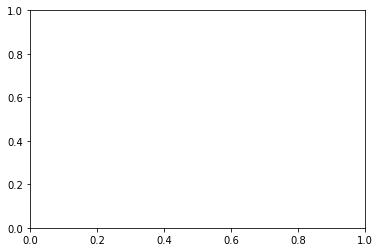

In [14]:
i=2
plt.plot(train_set[i*block_size:(i+1)*block_size,:])

In [ ]:
scaling = train_set.max() if scaled else 1
train_set = torch.unsqueeze(train_set,1)/scaling

In [ ]:
params_ = torch.linspace(5e-3,5e-2,20).unsqueeze(1)
params_ = torch.stack([params_,params_],-1)
params_.shape

torch.Size([20, 1, 2])

In [33]:
def get_batch():
    # [0,...,batch_time]
    
    batch_t = torch.arange(batch_time).float()
        
    # first index of each block [0,400,800,1200,...,7600]
    start_idx = torch.arange(0,8000,block_size)
    
    # generate a random t0 for each block
    s = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time-leave_out_for_time_test), batch_size, replace=False))
    # shift to match indexes 
    s = start_idx + s
    
    # select u0 + params
    batch_u0 = train_set[s,:,:].float()
    # select parameters
    batch_u0_param = torch.stack([batch_u0,params_ ],1)
    
    # u(0),..., u(batch_time)
    batch_u = torch.stack([train_set[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0_param.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

In [36]:
batch_u0.shape

torch.Size([20, 2, 1, 2])

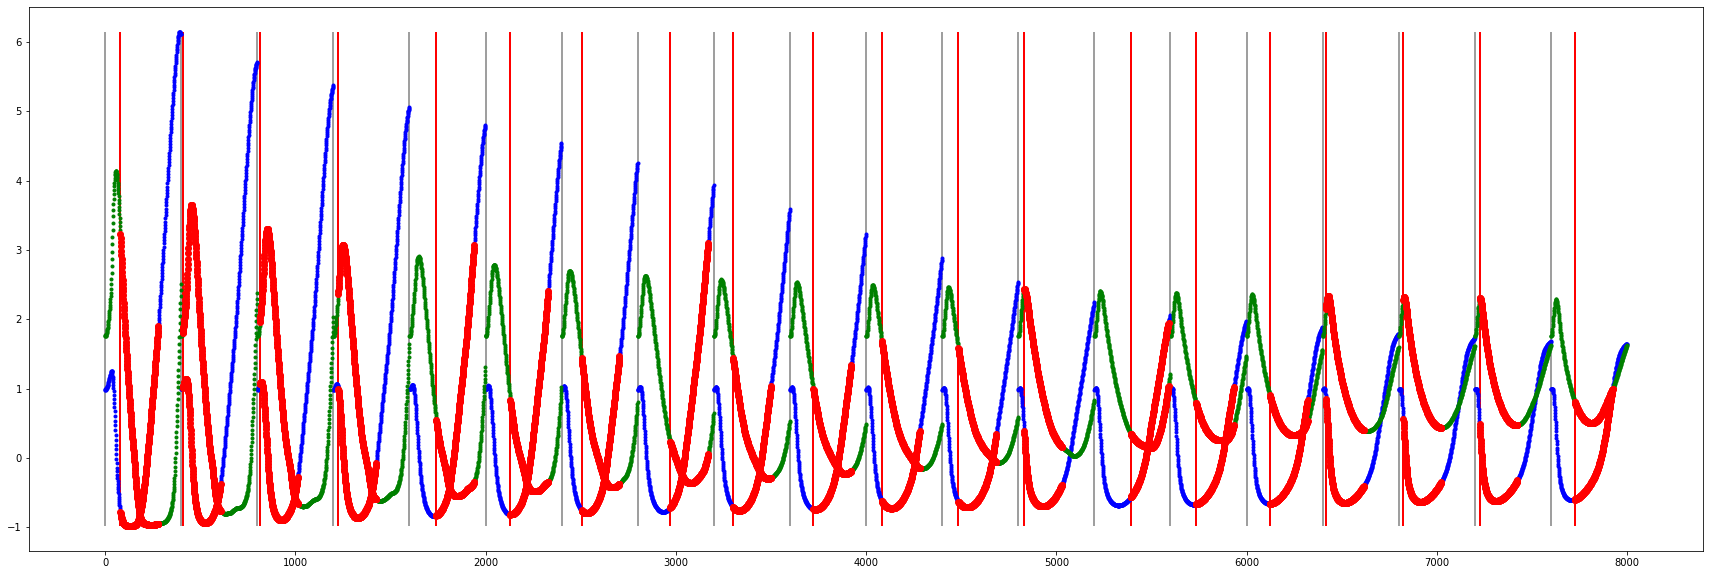

In [35]:
# VISUAL CHECK OF BATCHED DATA

with torch.no_grad():
    batch_u0, batch_u, batch_t, s = get_batch()

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,8000,400),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='red',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'.b')
    plt.plot(train_set[:,:,1].cpu(),'.g')
    for jj in range(batch_size):
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,0].cpu(),'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,1].cpu(),'or')

In [156]:
class ConvODEFunc(nn.Module):
    def __init__(self):
        super(ConvODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(1,1), stride=1, padding='same'),
            nn.Flatten(),
            nn.Linear(16,50),
            nn.Tanh(),
            nn.Linear(50,2)
            #nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(1,1), stride=1, padding='same'),
        )
        
        
    def forward(self, t, y):
        o1 = self.net(y)
        o = torch.stack([o1,torch.zeros_like(o1)],1)
        return o.unsqueeze(2)

In [157]:
func = ConvODEFunc().to(device)

In [158]:
batch_u0, batch_u, batch_t, _ = get_batch()

func.forward(0,batch_u0).shape

torch.Size([20, 2, 1, 2])

In [159]:
batch_u0, batch_u, batch_t, _ = get_batch()
pred_u = odeint(func, batch_u0, batch_t).to(device)

In [160]:
pred_u[:,:,0,:,:].shape, batch_u.shape

(torch.Size([200, 20, 1, 2]), torch.Size([200, 20, 1, 2]))

In [161]:
lrate = 1e-3
optimizer = optim.Adam(func.parameters(), lr=lrate)
itr_time = []
loss_array = []
for itr in range(1, niters + 1):

        start_itr = time.time()
        batch_u0, batch_u, batch_t, _ = get_batch()
        pred_u = odeint(func, batch_u0, batch_t).to(device)
        
        loss = torch.mean(torch.pow(pred_u[:,:,0,:,:] - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6)))

        if itr % freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s')
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1


'Iter 2000/2000  |  Loss: 0.057556'

Iter 2000/2000	|  Loss: 0.057556	|  lr: 0.001	|  itr time: 0.63426 s


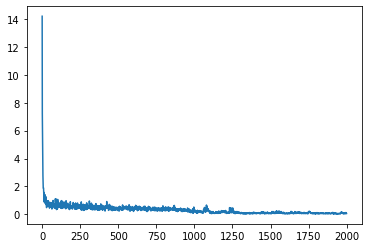

In [162]:
plt.plot(loss_array)

In [ ]:
pred_u.shape

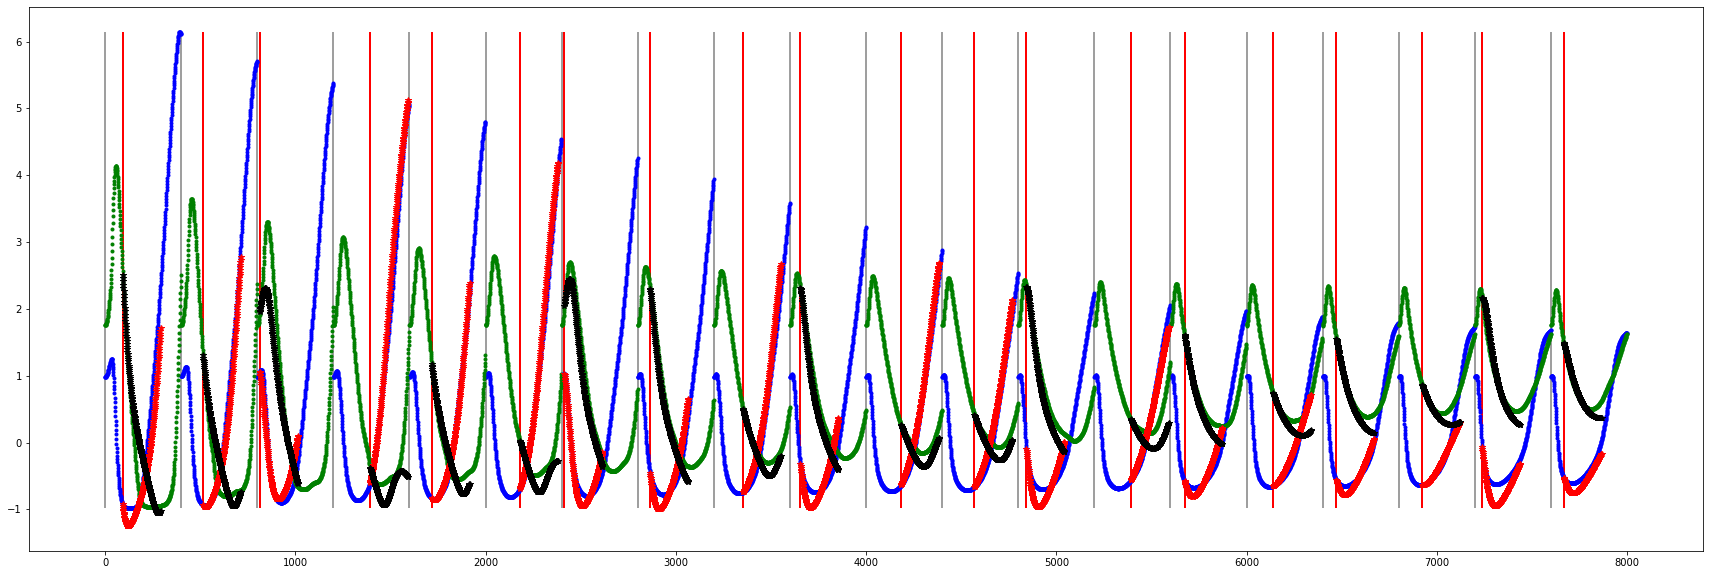

In [167]:
with torch.no_grad():
    batch_u0_param, batch_u, batch_t, s = get_batch()
    pred_u = odeint(func, batch_u0_param, batch_t)

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,8000,400),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='red',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'.b')
    plt.plot(train_set[:,:,1].cpu(),'.g')
    for jj in range(batch_size):
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,0,:,0].cpu(),'*r')
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,0,:,1].cpu(),'*k')

In [168]:
lrate = 1e-4
optimizer = optim.RMSprop(func.parameters(), lr=lrate)
itr_time = []
loss_array = []
for itr in range(1, 250 + 1):

        start_itr = time.time()
        batch_u0, batch_u, batch_t, _ = get_batch()
        pred_u = odeint(func, batch_u0, batch_t).to(device)
        
        loss = torch.mean(torch.pow(pred_u[:,:,0,:,:] - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6)))

        if itr % freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s')
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1


'Iter 250/2000  |  Loss: 0.159595'

In [171]:
def get_batch_test():
    # [0,...,batch_time]
    
    batch_t = torch.arange(block_size).float()
        
    # first index of each block [0,400,800,1200,...,7600]
    start_idx = torch.arange(0,8000,block_size)
    
    # generate a random t0 for each block
    #s = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time-leave_out_for_time_test), batch_size, replace=False))
    # shift to match indexes 
    s = start_idx
    
    # select u0 + params
    batch_u0 = train_set[s,:,:].float()
    # select parameters
    batch_u0_param = torch.stack([batch_u0,params_ ],1)
    
    # u(0),..., u(batch_time)
    batch_u = torch.stack([train_set[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0_param.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

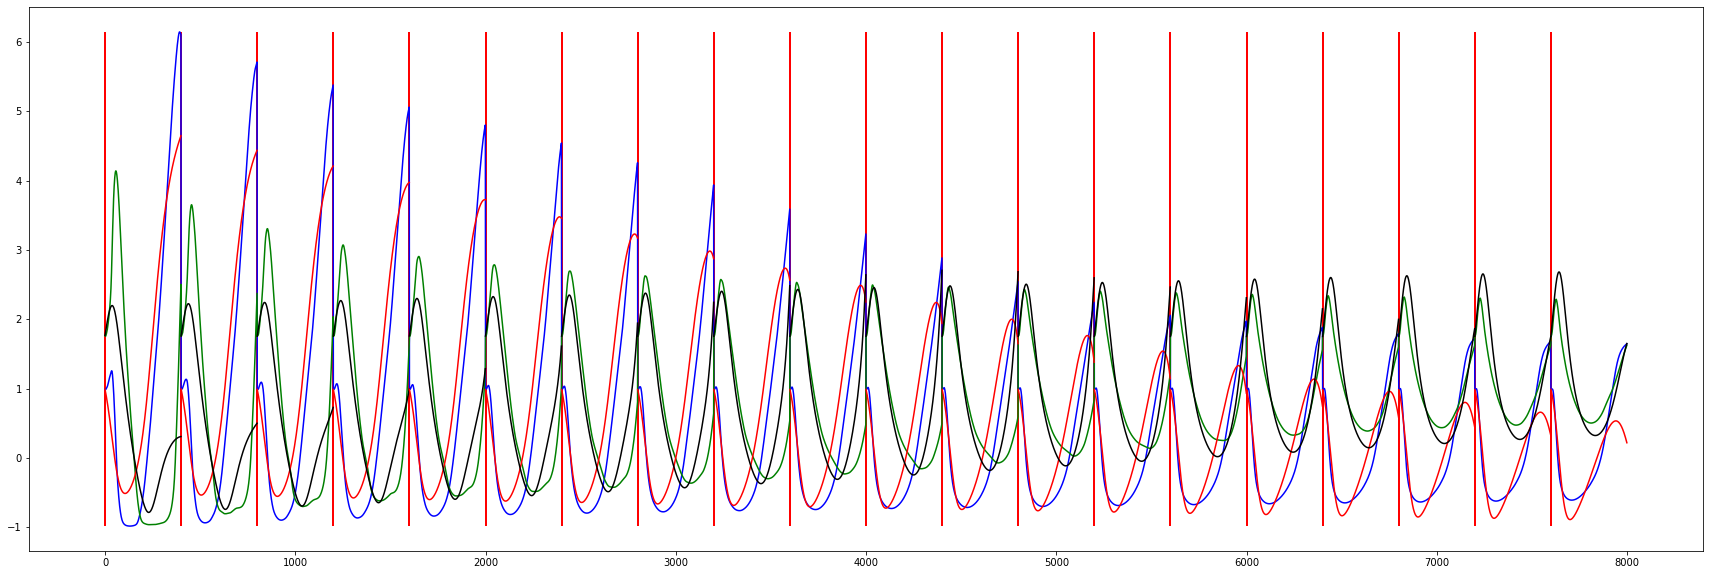

In [174]:
with torch.no_grad():
    batch_u0_param, batch_u, batch_t, s = get_batch_test()
    pred_u = odeint(func, batch_u0_param, batch_t)

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,8000,400),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='red',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'-b')
    plt.plot(train_set[:,:,1].cpu(),'-g')
    for jj in range(batch_size):
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,0,:,0].cpu(),'-r')
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,0,:,1].cpu(),'-k')